In [3]:
import sys

import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, KFold
from scipy.stats import kurtosis, skew
from numpy.linalg import cond, det
import matplotlib.pyplot as plt


sys.path.append("../")
from utils import load_data, StrokeParams, FetalHealthParams


def calculate_colinearity_metrics(dataframe):
    corr_matrix = dataframe.corr()
    condition_number = cond(corr_matrix)
    determinant = det(corr_matrix)
    sum_off_diagonal = np.sum(np.abs(corr_matrix.values)) - np.sum(
        np.diag(np.abs(corr_matrix.values))
    )
    return condition_number, determinant, sum_off_diagonal


# def pca_experiment(X, n_components_range):
#     results = []

#     for n_components in n_components_range:
#         # Applying PCA
#         pca = PCA(n_components=n_components)
#         X_pca = pca.fit_transform(X)

#         # Convert to DataFrame for easier calculation of metrics
#         df_pca = pd.DataFrame(X_pca)

#         # Calculate collinearity metrics
#         condition_number, determinant, sum_off_diagonal = calculate_colinearity_metrics(
#             df_pca
#         )

#         # Calculate skewness and kurtosis for each component
#         skewness = df_pca.apply(lambda x: skew(x), axis=0).mean()
#         kurt = df_pca.apply(lambda x: kurtosis(x, fisher=True), axis=0).mean()

#         results.append(
#             {
#                 "n_components": n_components,
#                 "condition_number": condition_number,
#                 "determinant": determinant,
#                 "sum_off_diagonal": sum_off_diagonal,
#                 "average_skewness": skewness,
#                 "average_kurtosis": kurt,
#                 "explained_variance_ratio": np.sum(pca.explained_variance_ratio_),
#             }
#         )

#         print(
#             f"n_components: {n_components}, Condition Number: {condition_number}, Determinant: {determinant}, "
#             f"Sum Off-Diagonal: {sum_off_diagonal}, Average Skewness: {skewness}, Average Kurtosis: {kurt}, "
#             f"Explained Variance Ratio: {np.sum(pca.explained_variance_ratio_)}"
#         )

#     return pd.DataFrame(results)


def pca_experiment(X, n_components_range, n_splits=3, random_state: int = 666):
    results = []
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    for n_components in n_components_range:
        # Initialize variables to store cross-validated metrics
        condition_numbers = []
        determinants = []
        sums_off_diagonal = []
        average_skewnesses = []
        average_kurtoses = []
        explained_variance_ratios = []

        for train_index, test_index in kf.split(X):
            # Split the data into training and test sets
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]

            # Fit the PCA object to the training set and transform the test set
            pca = PCA(n_components=n_components)
            X_test_pca = pca.fit(X_train).transform(X_test)

            # Convert to DataFrame for easier calculation of metrics
            df_pca = pd.DataFrame(X_test_pca)

            # Calculate collinearity metrics
            condition_number, determinant, sum_off_diagonal = (
                calculate_colinearity_metrics(df_pca)
            )

            # Calculate skewness and kurtosis for each component
            skewness = df_pca.apply(lambda x: skew(x), axis=0).mean()
            kurt = df_pca.apply(lambda x: kurtosis(x, fisher=True), axis=0).mean()

            # Record the metrics for this fold
            condition_numbers.append(condition_number)
            determinants.append(determinant)
            sums_off_diagonal.append(sum_off_diagonal)
            average_skewnesses.append(skewness)
            average_kurtoses.append(kurt)
            explained_variance_ratios.append(np.sum(pca.explained_variance_ratio_))

        # Append the average results across folds for this number of components
        results.append(
            {
                "n_components": n_components,
                "avg_condition_number": np.mean(condition_numbers),
                "avg_determinant": np.mean(determinants),
                "avg_sum_off_diagonal": np.mean(sums_off_diagonal),
                "avg_skewness": np.mean(average_skewnesses),
                "avg_kurtosis": np.mean(average_kurtoses),
                "avg_explained_variance_ratio": np.mean(explained_variance_ratios),
                "std_explained_variance_ratio": np.std(explained_variance_ratios),
            }
        )

        print(
            f"n_components: {n_components}, Average Condition Number: {np.mean(condition_numbers)}, "
            f"Average Determinant: {np.mean(determinants)}, Average Sum Off-Diagonal: {np.mean(sums_off_diagonal)}, "
            f"Average Skewness: {np.mean(average_skewnesses)}, Average Kurtosis: {np.mean(average_kurtoses)}, "
            f"Average Explained Variance Ratio: {np.mean(explained_variance_ratios)}"
        )

    return pd.DataFrame(results)


def plot_pca_eigenvalues(dataset, n_components, title, filepath: str = None):
    # Perform PCA without reducing dimensionality to get all eigenvalues
    pca = PCA(n_components=n_components).fit(dataset)

    # Eigenvalues (explained variance)
    eigenvalues = pca.explained_variance_

    # Plotting the explained variances (eigenvalues) of the components
    plt.figure(figsize=(8, 4))
    plt.plot(
        np.arange(1, len(eigenvalues) + 1),
        eigenvalues,
        "o-",
        linewidth=2,
        label="Explained variance",
    )
    plt.title(title)
    plt.xlabel("Principal Component")
    plt.ylabel("Eigenvalue (Explained Variance)")
    plt.xticks(np.arange(1, len(eigenvalues) + 1))
    plt.grid(True)
    plt.legend()

    if filepath:
        plt.savefig(filepath)
    plt.show()


def plot_explained_variance(dataset, n_components_range, title, filepath: str = None):
    explained_var_ratios = []

    # Perform PCA for each number of components to get the explained variance ratio
    for n_components in n_components_range:
        pca = PCA(n_components=n_components)
        pca.fit(dataset)
        explained_var_ratios.append(np.sum(pca.explained_variance_ratio_))

    # Plot the cumulative explained variance ratio as a function of the number of components
    plt.figure(figsize=(10, 6))
    plt.plot(n_components_range, explained_var_ratios, "o-", linewidth=2, color="blue")
    plt.title(title)
    plt.xlabel("Number of Components")
    plt.ylabel("Cumulative Explained Variance Ratio")
    plt.grid(True)
    if filepath:
        plt.savefig(filepath)
    plt.show()


if __name__ == "__main__":
    # load data
    strokeX_all, strokeY = load_data(
        StrokeParams.data_train, StrokeParams.target_column
    )
    strokeX = strokeX_all.drop(columns=StrokeParams.cat_cols)
    fetalX_all, fetalY = load_data(
        FetalHealthParams.data_train, FetalHealthParams.target_column
    )
    fetalX = fetalX_all.drop(columns=FetalHealthParams.cat_cols)

Stroke Dataset
n_components: 2, Average Condition Number: 1.0619193364731412, Average Determinant: 0.9990178843519395, Average Sum Off-Diagonal: 0.05988462919284979, Average Skewness: 0.4310902643154271, Average Kurtosis: -1.0216384288877025, Average Explained Variance Ratio: 0.3294510468881344
n_components: 3, Average Condition Number: 1.0764880350801502, Average Determinant: 0.9984443438082685, Average Sum Off-Diagonal: 0.118098051460378, Average Skewness: 0.39477394524193193, Average Kurtosis: -0.9608378889614425, Average Explained Variance Ratio: 0.4232138935185721
n_components: 4, Average Condition Number: 1.1572000197217134, Average Determinant: 0.9938268781742163, Average Sum Off-Diagonal: 0.29436373772683816, Average Skewness: 0.35887301649319264, Average Kurtosis: -0.6579877513082187, Average Explained Variance Ratio: 0.49989940112700076
n_components: 5, Average Condition Number: 1.8415432032327386, Average Determinant: 0.9057111069227582, Average Sum Off-Diagonal: 1.036906972

,n_components,avg_condition_number,avg_determinant,avg_sum_off_diagonal,avg_skewness,avg_kurtosis,avg_explained_variance_ratio,std_explained_variance_ratio
0,2,1.061919,0.999018,0.059885,0.431090,-1.021638,0.329451,6.924520e-03
1,3,1.076488,0.998444,0.118098,0.394774,-0.960838,0.423214,8.719112e-03
2,4,1.157200,0.993827,0.294364,0.358873,-0.657988,0.499899,9.186113e-03
3,5,1.841543,0.905711,1.036907,0.644422,3.115916,0.567049,9.967101e-03
4,6,1.974026,0.886464,1.458080,0.632149,2.851494,0.631392,9.506723e-03
5,7,2.175693,0.861079,1.910252,0.536385,2.540260,0.692571,9.842804e-03
6,8,2.202746,0.853172,2.300633,0.512131,2.475615,0.749833,1.029678e-02
7,9,2.319135,0.835857,2.870522,0.696118,4.946803,0.803080,7.232032e-03
8,10,2.386155,0.817867,3.549013,0.666315,4.563975,0.849392,4.441800e-03
9,11,2.418596,0.805312,4.168944,0.643719,4.348278,0.893042,3.451039e-03


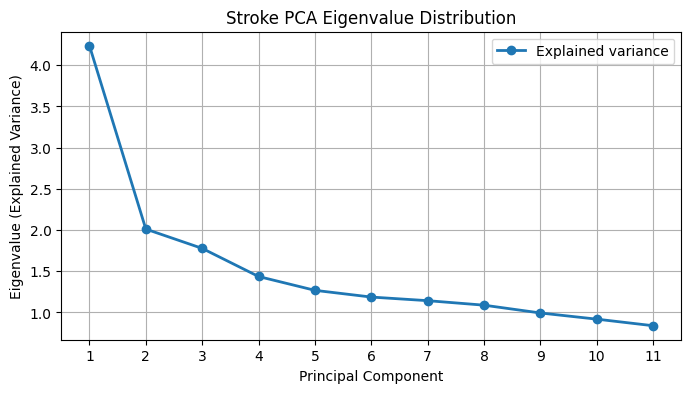

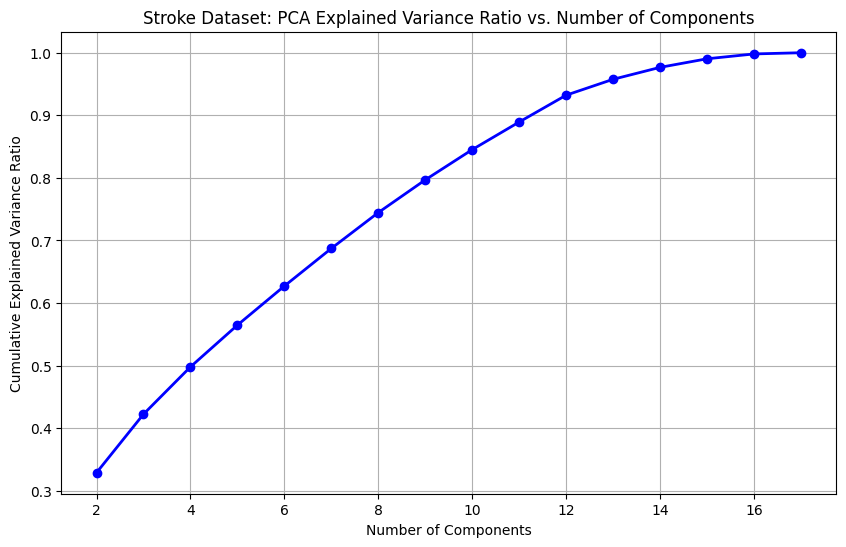

In [4]:
if __name__ == "__main__":
    # Stroke dataset
    print("Stroke Dataset")
    n_components_range = range(2, strokeX_all.shape[1] - 1)
    stroke_results_df = pca_experiment(strokeX_all, n_components_range)
    display(stroke_results_df)

    plot_pca_eigenvalues(
        strokeX_all,
        11,
        "Stroke PCA Eigenvalue Distribution",
        "stroke_pca_eigenvalues.png",
    )

    plot_explained_variance(
        strokeX_all,
        n_components_range,
        "Stroke Dataset: PCA Explained Variance Ratio vs. Number of Components",
        "stroke_explained_variance.png",
    )

Stroke Dataset


""


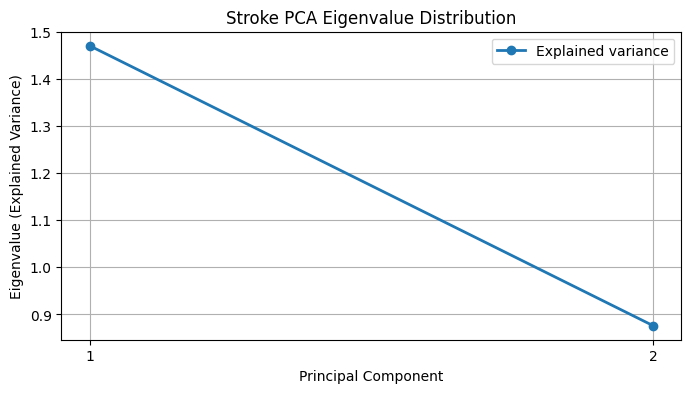

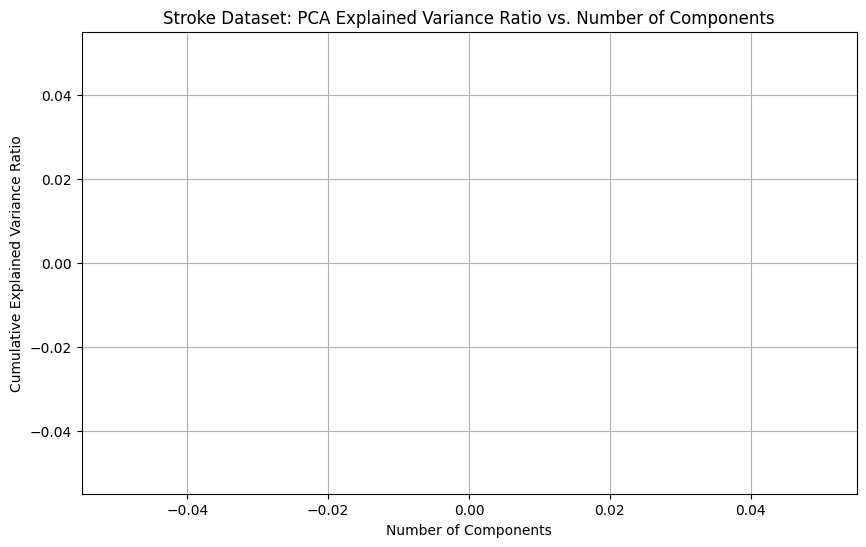

In [11]:
if __name__ == "__main__":
    # Stroke dataset
    print("Stroke Dataset")
    n_components_range = range(2, strokeX.shape[1] - 1)
    stroke_results_df = pca_experiment(strokeX, n_components_range)
    display(stroke_results_df)

    plot_pca_eigenvalues(
        strokeX,
        2,
        "Stroke PCA Eigenvalue Distribution",
        # "stroke_pca_eigenvalues.png"
    )

    plot_explained_variance(
        strokeX,
        n_components_range,
        "Stroke Dataset: PCA Explained Variance Ratio vs. Number of Components",
        # "stroke_explained_variance.png",
    )

Fetal Health Dataset
n_components: 2, Average Condition Number: 1.1668749950226247, Average Determinant: 0.9904806867867972, Average Sum Off-Diagonal: 0.14386665617778, Average Skewness: 2.1733676030961933, Average Kurtosis: 12.311567910488884, Average Explained Variance Ratio: 0.5448007604084676
n_components: 3, Average Condition Number: 1.4902029201508242, Average Determinant: 0.9522919121243044, Average Sum Off-Diagonal: 0.5260507869141392, Average Skewness: 2.0977634557006777, Average Kurtosis: 11.522714401029432, Average Explained Variance Ratio: 0.65243621747004
n_components: 4, Average Condition Number: 1.5969310297566923, Average Determinant: 0.9362486237033331, Average Sum Off-Diagonal: 0.8652938519536079, Average Skewness: 1.7521936668028713, Average Kurtosis: 9.139656976103732, Average Explained Variance Ratio: 0.7168362812001274
n_components: 5, Average Condition Number: 1.6100044887763953, Average Determinant: 0.9320369740964491, Average Sum Off-Diagonal: 1.056551713193221

,n_components,avg_condition_number,avg_determinant,avg_sum_off_diagonal,avg_skewness,avg_kurtosis,avg_explained_variance_ratio,std_explained_variance_ratio
0,2,1.166875,0.990481,0.143867,2.173368,12.311568,0.544801,0.001972
1,3,1.490203,0.952292,0.526051,2.097763,11.522714,0.652436,0.004069
2,4,1.596931,0.936249,0.865294,1.752194,9.139657,0.716836,0.003438
3,5,1.610004,0.932037,1.056552,1.692043,8.476882,0.767338,0.002674
4,6,1.653482,0.926152,1.365221,1.427798,7.053271,0.811602,0.001914
5,7,1.757247,0.907538,1.881209,1.241258,6.286040,0.842367,0.001496
6,8,1.829452,0.890214,2.451698,1.120903,5.693003,0.871492,0.001483
7,9,1.860903,0.880491,2.920214,1.165822,6.170310,0.896943,0.001283
8,10,1.903056,0.862714,3.563193,1.076892,5.785381,0.917879,0.001329
9,11,1.957379,0.844938,4.303999,0.982749,5.313792,0.937658,0.001002


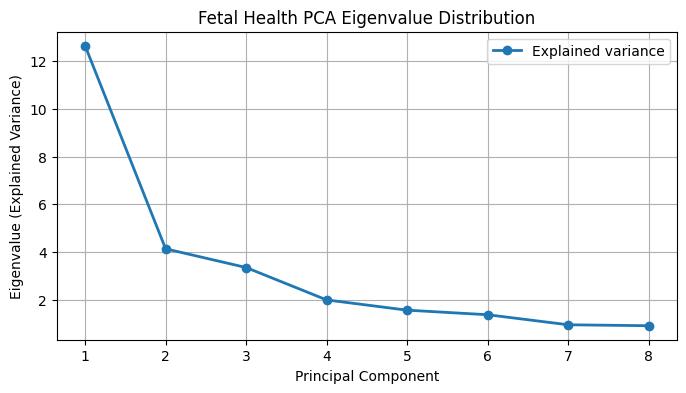

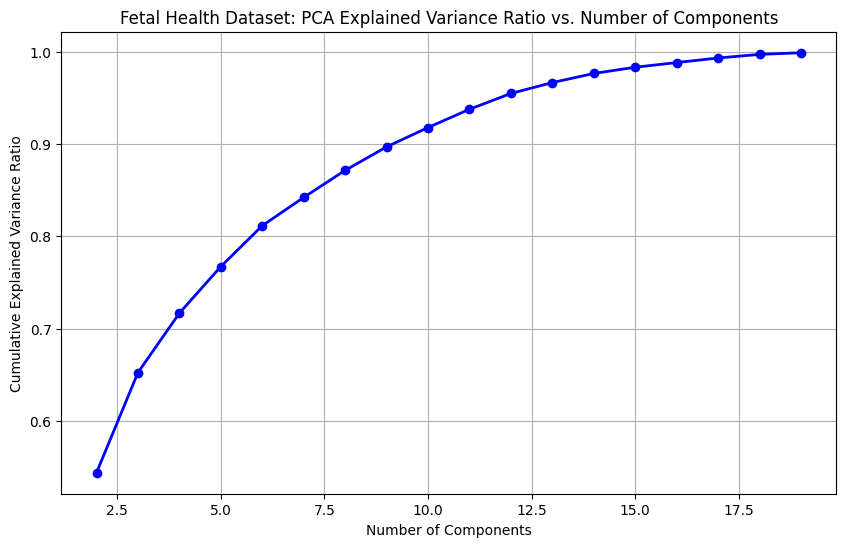

In [ ]:
if __name__ == "__main__":
    # fetal health dataset
    print("Fetal Health Dataset")
    n_components_range = range(2, fetalX.shape[1] - 1)
    results_df = pca_experiment(fetalX, n_components_range)
    display(results_df)

    plot_pca_eigenvalues(
        fetalX,
        8,
        "Fetal Health PCA Eigenvalue Distribution",
        "fetal_pca_eigenvalues.png",
    )

    plot_explained_variance(
        fetalX,
        n_components_range,
        "Fetal Health Dataset: PCA Explained Variance Ratio vs. Number of Components",
        "fetal_explained_variance.png",
    )

# Optimal PCA

In [4]:
if __name__ == "__main__":
    # perform PCA on stroke dataset
    stroke_n_components = 2
    stroke_pca = PCA(n_components=stroke_n_components)
    strokeX_pca = stroke_pca.fit_transform(strokeX)
    strokeX_pca = pd.DataFrame(strokeX_pca)
    strokeX_pca.columns = [f"PC{i}" for i in range(stroke_n_components)]
    strokeX_pca[StrokeParams.target_column] = strokeY

    # save results
    strokeX_pca.to_csv(f"stroke_pca_{stroke_n_components}.csv", index=False)

    # perform PCA on stroke dataset
    stroke_all_n_components = 11
    stroke_all_pca = PCA(n_components=stroke_all_n_components)
    strokeX_all_pca = stroke_all_pca.fit_transform(strokeX_all)
    strokeX_all_pca = pd.DataFrame(strokeX_all_pca)
    strokeX_all_pca.columns = [f"PC{i}" for i in range(stroke_all_n_components)]
    strokeX_all_pca[StrokeParams.target_column] = strokeY

    strokeX_all_test, strokeY_test = load_data(StrokeParams.data_test, StrokeParams.target_column)
    strokeX_all_test_pca = stroke_all_pca.transform(strokeX_all_test)
    strokeX_all_test_pca = pd.DataFrame(strokeX_all_test_pca)
    strokeX_all_test_pca.columns = [f"PC{i}" for i in range(stroke_all_n_components)]
    strokeX_all_test_pca[StrokeParams.target_column] = strokeY_test

    # save results
    strokeX_all_pca.to_csv(f"stroke_all_pca_{stroke_all_n_components}.csv", index=False)
    strokeX_all_test_pca.to_csv(f"stroke_all_test_pca_{stroke_all_n_components}.csv", index=False)

    # perform PCA on fetal health dataset
    fetal_health_n_components = 8
    fetal_health_pca = PCA(n_components=fetal_health_n_components)
    fetalX_pca = fetal_health_pca.fit_transform(fetalX)
    fetalX_pca = pd.DataFrame(fetalX_pca)
    fetalX_pca.columns = [f"PC{i}" for i in range(fetal_health_n_components)]
    fetalX_pca[FetalHealthParams.target_column] = fetalY

    fetalX_test, fetalY_test = load_data(FetalHealthParams.data_test, FetalHealthParams.target_column)
    fetalX_test = fetalX_test.drop(columns=FetalHealthParams.cat_cols)
    fetalX_test_pca = fetal_health_pca.transform(fetalX_test)
    fetalX_test_pca = pd.DataFrame(fetalX_test_pca)
    fetalX_test_pca.columns = [f"PC{i}" for i in range(fetal_health_n_components)]
    fetalX_test_pca[FetalHealthParams.target_column] = fetalY_test

    # save results
    fetalX_pca.to_csv(f"fetal_health_pca_{fetal_health_n_components}.csv", index=False)
    fetalX_test_pca.to_csv(f"fetal_health_test_pca_{fetal_health_n_components}.csv", index=False)

# Noisy PCA

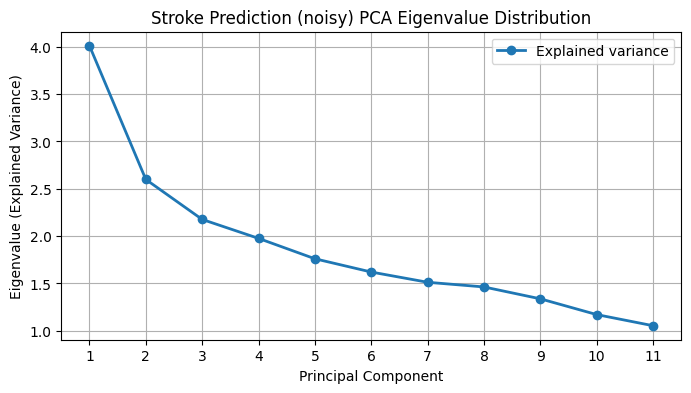

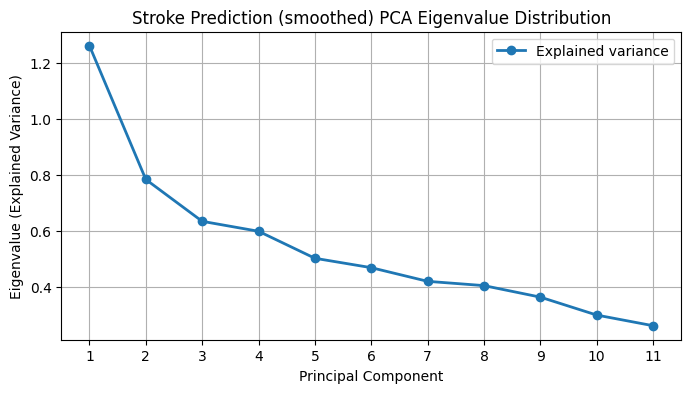

In [ ]:
if __name__ == "__main__":
    # load noisy and smoothed data
    strokeX_noisy = pd.read_csv("strokeX_noisy.csv")
    strokeX_smoothed = pd.read_csv("strokeX_smoothed.csv")

    # perform PCA on noisy and smoothed data
    stroke_n_components = 11
    stroke_pca = PCA(n_components=stroke_n_components)

    strokeX_noisy_pca = stroke_pca.fit_transform(strokeX_noisy)
    strokeX_noisy_pca = pd.DataFrame(strokeX_noisy_pca)

    strokeX_smoothed_pca = stroke_pca.fit_transform(strokeX_smoothed)
    strokeX_smoothed_pca = pd.DataFrame(strokeX_smoothed_pca)

    # plot results on noisy and smoothed data
    plot_pca_eigenvalues(
        strokeX_noisy_pca,
        stroke_n_components,
        "Stroke Prediction (noisy) PCA Eigenvalue Distribution",
        "stroke_noisy_pca_eigenvalues.png",
    )

    plot_pca_eigenvalues(
        strokeX_smoothed_pca,
        stroke_n_components,
        "Stroke Prediction (smoothed) PCA Eigenvalue Distribution",
        "stroke_smoothed_pca_eigenvalues.png",
    )

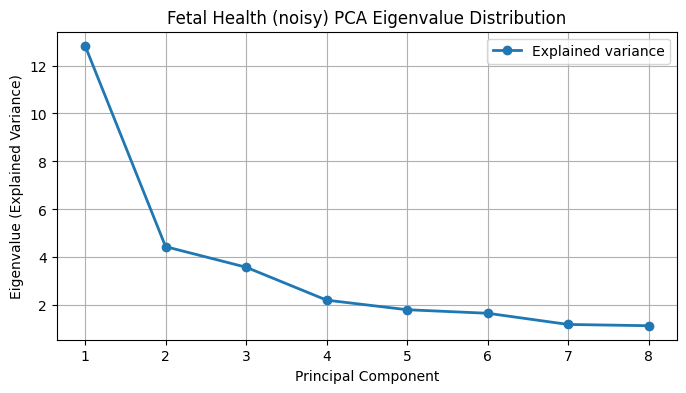

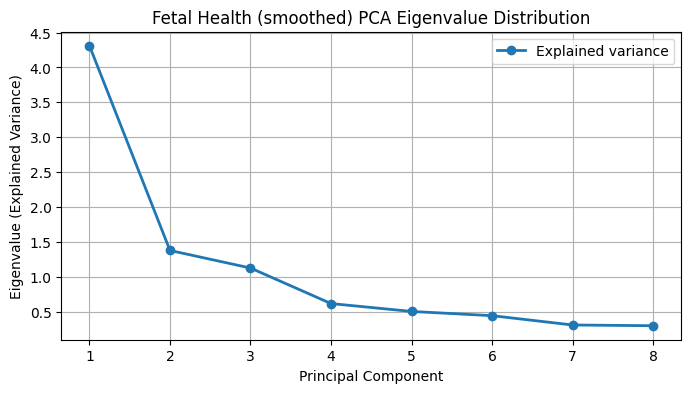

In [ ]:
if __name__ == "__main__":
    # load noisy and smoothed data
    fetalX_noisy = pd.read_csv("fetal_health_noisy.csv")
    fetalX_smoothed = pd.read_csv("fetal_health_smoothed.csv")

    # perform PCA on noisy and smoothed data
    fetal_health_n_components = 8
    fetal_health_pca = PCA(n_components=fetal_health_n_components)

    fetalX_noisy_pca = fetal_health_pca.fit_transform(fetalX_noisy)
    fetalX_noisy_pca = pd.DataFrame(fetalX_noisy_pca)

    fetalX_smoothed_pca = fetal_health_pca.fit_transform(fetalX_smoothed)
    fetalX_smoothed_pca = pd.DataFrame(fetalX_smoothed_pca)

    # plot results on noisy and smoothed data
    plot_pca_eigenvalues(
        fetalX_noisy_pca,
        fetal_health_n_components,
        "Fetal Health (noisy) PCA Eigenvalue Distribution",
        "fetal_noisy_pca_eigenvalues.png",
    )

    plot_pca_eigenvalues(
        fetalX_smoothed_pca,
        fetal_health_n_components,
        "Fetal Health (smoothed) PCA Eigenvalue Distribution",
        "fetal_smoothed_pca_eigenvalues.png",
    )